# Anomaly Detection and Recommender Systems

## 1 Anomaly detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset $x^{(1)}, x^{(2)},..., x^{(m)}$. You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset. 

You will use a Gaussian model to detect anomalous examples in your dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Update the matplotlib configuration parameters:
matplotlib.rcParams.update({'font.size': 16, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [3]:
# load data
from scipy.io import loadmat

data = loadmat('ex8data1.mat')

X = data['X']
Xval = data['Xval']
yval = data['yval']

In [4]:
def plotData(X):
    """ plot training sample X
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(X[:, 0], X[:, 1], 'bx')
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Throughput (MB/s)')
    ax.set_aspect('equal')
    
    return fig, ax

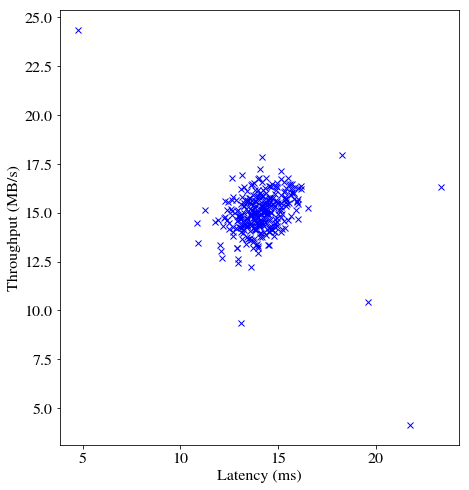

In [5]:
# Visualizing training samples
fig, ax = plotData(X)

### 1.1 Gaussian distribution

Given a training set ${x^{(1)}, x^{(2)},..., x^{(m)}}$ where $x^{(i)}\in \mathbb R^n$, we will fit each of the features $x^{(i)}$ into a Gasussian distribution. The Gaussian distribution is given by:

$$ p(x;\mu, \sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

where $\mu$ is the mean and $\sigma^2$ is the variance. 

### 1.2 Estimating parameters for a Gaussian distribution

The parameters, $(\mu_i, \sigma_i^2)$, of the i-th feature can be estimated by the following equation:

$$ \mu_i = \frac{1}{m}\sum_{j=1}^{m} x_i^{(j)}$$

$$ \sigma_i^2 = \frac{1}{m}\sum_{j=1}^{m} (x_i^{(j)} - \mu_i)^2 $$

In [6]:
def estimateGaussian(X):
    """ estimates the parameters of a Gaussian distribution using the data in X
    """
    
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)   # degree of freedom is m (number of samples)
    
    return mu, sigma2

In [7]:
mu, sigma2 = estimateGaussian(X)
print(mu.shape)
print(sigma2.shape)

(2,)
(2,)


### 1.3 Probability density function for Multivariate Gaussian Distribution

The Probability density function for Multivariate Gaussian Distribution is given by: 

$$ p(x;\mu, \Sigma)=\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp\left(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)\right)$$

where $\Sigma$ is covariance matrix. Here, when we only consider distributions that are independent with each other, $\Sigma$ becomes a diagonal matrix with variances on the diagonal axis:

$$ \Sigma = \left[ \matrix{\sigma_1^2 & 0 & ...\cr 0 & \sigma_2^2 & ... \cr ...&...&...}\right]$$

$x$ and $\mu$ are vectors belonging to $\mathbb R^n$. 

To use X, where each row represents an sample point $x$, in the above vectorized equation, need to use a revised version: 

$$ p(X;\mu, \Sigma)=diag\left(\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp\left(-\frac{1}{2}(X-\mu) \Sigma^{-1}(X-\mu)^T\right)\right)$$

$diag()$ function extracts the diagonal elements of a matrix. The result p will be an m-element array, containing probability density for each of the m points.

In [8]:
def multivariateGaussian(X, mu, sigma2):
    """ Computes the probability density function of the
         multivariate Gaussian distribution
    """
    # num of variables
    n = len(mu)
    
    # construct diagonal matrix - the covariance matrix
    Sigma = np.diag(sigma2)
    # compute inverse of Sigma
    Sigma_inv = np.diag(1/sigma2)
    
    # compute multivariate Gaussian probability density
    P =  np.exp(-0.5*(X-mu)@Sigma_inv@(X-mu).T) / ((2*np.pi)**(n/2)*(np.linalg.det(Sigma)**0.5))
    
    # extract diagonal from matrix P
    p = np.diag(P)
    
    return p    

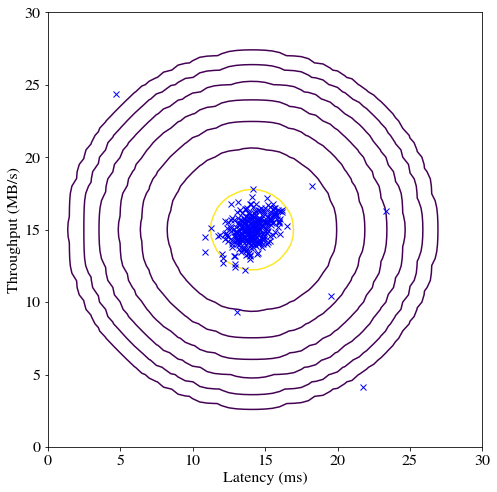

In [9]:
# Visualizing training samples
fig, ax = plotData(X)

# Visualizing Gaussian model
delta = 0.5
x = np.arange(0, 35, delta)
y = np.arange(0, 35, delta)
X0, X1 = np.meshgrid(x, y)

# format matrix to input to multivariateGaussian() function
# critical step!!!!!!!!!
input_X = np.vstack((X0.ravel(), X1.ravel())).T
p = multivariateGaussian(input_X, mu, sigma2)

# reshape to the size of the meshgrid
Z = p.reshape(X0.shape)

# draw contour lines at certain Z values
levels = np.logspace(-20, -2, 7)
CS = ax.contour(X0, X1, Z, levels)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_aspect('equal')

### 1.3 Selecting the threshold

Threshold $\epsilon$ is used to determine if an sample is an anomaly or not. If $p(x) \lt \epsilon$, $x$ is considered to be an anomaly (positive example, i.e. $y=1$).

In this part, we will use cross validation set as evaluation data and $F_1$ score as evaluation metric to select optimum threshold. The $F_1$ score is computed using precision (prec) and recall (rec):

$$ F_1 = \frac{2\cdot prec\cdot rec}{prec+rec}$$

Precision is the ratio of correct prediction among all samples that are predicted 'positive'; recall is the ratio of correct prediction among all samples that are truly positive. 

Precision and recall are computed by: 
$$ prec = \frac{tp}{tp+fp}$$

$$ rec = \frac{tp}{tp+fn}$$

where $tp$, $fp$, $fn$ are the number of true positives, false positives, false negatives, respectively. 

In [10]:
def selectThreshold(yval, pval):
    """ Find the best threshold (epsilon) to use for selecting outliers
    """
    
    # init
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
        
    for epsilon in np.linspace(np.min(pval), np.max(pval), 1000):
        
        # predict y based on epsilon
        ypre = np.zeros(yval.shape)
        ypre[pval < epsilon] = 1
        
        # prepare for tp, fp and fn calculation
        s = yval + ypre
        d = yval - ypre
        
        # compute tp, fp and fn
        tp = np.sum(s==2) # total number of cases where yval=ypre=1
        fp = np.sum(d==-1) # total number of cases where yval=0, ypre=1
        fn = np.sum(d==1) # total number of cases where yval=1, ypre=0
        
        # avoid division by zero
        # when epsilon=min(pval), there will be no positive predictions
        # so, tp + fp will be zero
        if (tp+fp) != 0 and (tp+fn) != 0:
            
            # compute precision and recall
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
        
            # compute F1
            F1 = 2 * prec * rec / (prec + rec)
            
        else:
            F1 = 0
        
#         # debugging
#         F1_history[i] = F1
#         i += 1
        
        # update best epsilon
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
        
    return bestEpsilon, bestF1

In [11]:
# Select threshold with cross validation dataset
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print("Epsilon: {:.4e}; F1: {:.4f}".format(epsilon, F1))
print("Expected Epsilon: 8.99e-05, F1: 0.875")

# Use selected threshold to find outliers
p = multivariateGaussian(X, mu, sigma2)
outliers = p < epsilon
print("Number of outliers is {}".format(np.sum(outliers)))

Epsilon: 8.9999e-05; F1: 0.8750
Expected Epsilon: 8.99e-05, F1: 0.875
Number of outliers is 6


#### Visualizing outliers

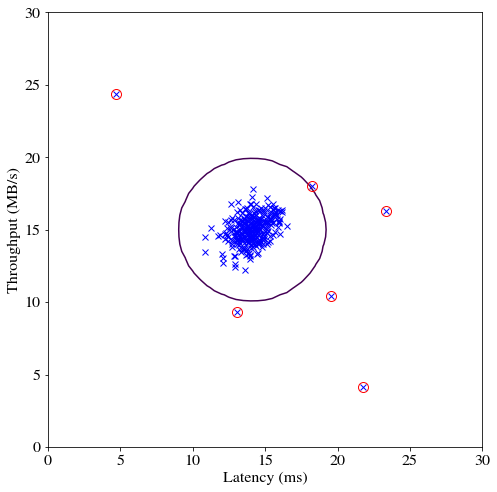

In [12]:
# visualization
# Visualizing training samples
fig, ax = plotData(X)

# visualizing Gaussian model
delta = 0.5
x = np.arange(0, 35, delta)
y = np.arange(0, 35, delta)
X0, X1 = np.meshgrid(x, y)

# format matrix to input to multivariateGaussian() function
# critical step!!!!!!!!!
input_X = np.vstack((X0.ravel(), X1.ravel())).T
p = multivariateGaussian(input_X, mu, sigma2)

# convert back to size of meshgrid
Z = p.reshape(X0.shape)

# draw contour line at level of epsilon
ax.contour(X0, X1, Z, levels=[epsilon])
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_aspect('equal')

# highlight outliers
ax.plot(X[outliers, 0], X[outliers, 1], 'ro', markersize=10, fillstyle='none')

### 1.4 High dimensional dataset

In this part, we will run the anomaly detection algorithm on a more realistic and much harder dataset. In this dataset, each example has 11 features, capturing many more properties of the computer servers in our problem formulation. 

In [13]:
# Load new dataset
data2 = loadmat('ex8data2.mat')

X = data2['X']
Xval = data2['Xval']
yval = data2['yval']

# compute Gaussian model
mu, sigma2 = estimateGaussian(X)

# get probability for sample points in X
p = multivariateGaussian(X, mu, sigma2)

# probabilities for cross validation samples
pval = multivariateGaussian(Xval, mu, sigma2)

# use pval to optimize choice of epsilon
epsilon, F1 = selectThreshold(yval, pval)

# print results and compare
print("Epsilon: {:.4e}; F1: {:.4f}".format(epsilon, F1))
print("Expected Epsilon: 1.38e-18, F1: 0.615385")

print("Number of outliers: {}".format(np.sum(p < epsilon)))
print("Expected number of outliers: 117")

Epsilon: 1.3786e-18; F1: 0.6154
Expected Epsilon: 1.38e-18, F1: 0.615385
Number of outliers: 117
Expected number of outliers: 117


## 2 Recommender Systems

In this part of the exercise, we will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 

### 2.1 Movie rating dataset

The matrix Y (a $n_m \times n_u$ matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5, unrated movies have rating of 0). The matrix R is an binary-valued indicator matrix, where $r^{(i,j)} = 1$ if user $j$ gave a rating to movie $i$, and $r^{(i, j)} = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $r^{(i,j)} = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user. 

In [14]:
# load data
data = loadmat('ex8_movies.mat')

# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
# R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
Y = data['Y']
R = data['R']

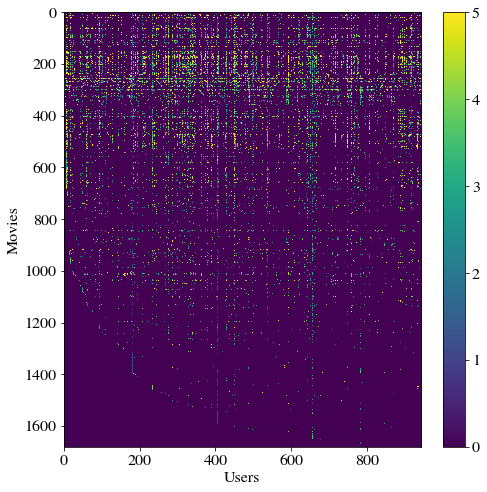

In [15]:
# Simple visualization
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
ax.set_aspect('auto')
fig.colorbar(im)

### 2.2 Collaborative filtering learning algorithm

The central idea of collaborative filtering is training both movie features (represented in $X$) and user preferences (represented in $\Theta$) collaboratively (using one to train another and vice versa). In actual implementation, both $X$ and $\Theta$ are trained at the same time within each iteration. 

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, ..., x^{(n_m)}$ and $\theta^{(1)}, ..., \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

#### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by: 
$$ J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)})=
\frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2 $$


With regularization terms, the equation becomes:

$$ J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)})=
\frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2 +
\left(\frac{\lambda}{2}\sum_{n_u}^{j=1}\sum_{n}^{k=1}(\theta_k^{(j)})^2\right) +
\left(\frac{\lambda}{2}\sum_{n_m}^{i=1}\sum_{n}^{k=1}(x_k^{(i)})^2\right)
$$

Considering that $X$ is of size $n_m \times n$ and $\Theta$ is of size $n_u \times n$, the vectorized cost function is given by: 

$$ J=\frac{1}{2} sum((X\Theta^T - Y).*(X\Theta^T - Y) .* (R==1)) + \frac{\lambda}{2}(sum(\Theta.*\Theta)+sum(X.*X))$$

where sum() performs summation across all elements in a matrix, and .* represents element-wise multiplication.

#### 2.2.2 Collaborative filtering gradient

The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})\theta_k^{(j)}+\lambda x_k^{(i)}$$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(i)}+\lambda \theta_k^{(j)}$$

Note that $\frac{\partial J}{\partial X}$ is of size $n_m \times n$, same as $X$; $\frac{\partial J}{\partial \Theta}$ is of size $n_u \times n$, same as $\Theta$. Therefore, the vectorized version will be:

$$ \frac{\partial J}{\partial X} = (X\Theta^T-Y).*R \cdot \Theta + \lambda X$$

$$ \frac{\partial J}{\partial \Theta} = ((X\Theta^T-Y).*R)^T \cdot X + \lambda \Theta$$

where .* represents element-wise multiplication.

In [16]:
def cofiCostFunc(params, Y, R, num_features, lmd):
    """returns the cost and gradient for the collaborative filtering problem
    """
    
    # get dimensions
    num_movies, num_users = Y.shape
    
    # recover X and Theta to matrix form
    # X is m by n, Theta is u by n
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
        
    # Cost without regularization
    J = 0.5 * np.sum((X@Theta.T - Y)**2*R)
    
    # regularization terms
    term1 = 0.5 * lmd * np.sum(Theta**2)
    term2 = 0.5 * lmd * np.sum(X**2)
    
    # Cost with regularization
    J += (term1+term2)
    
    # Gradient
    # X_grad should have same shape as X
    # Theta_grad should have same shape as Theta
    X_grad = (X@Theta.T - Y)*R @ Theta
    Theta_grad = ((X@Theta.T - Y)*R).T @ X
    
    # add regularization
    X_grad += lmd * X
    Theta_grad += lmd * Theta
    
    # ravel grad
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    
    return J, grad

In [17]:
# Test cofiCostFunc() on mini dataset
testdata = loadmat('ex8_movieParams.mat')

X_test = testdata['X']
Theta_test = testdata['Theta']

# Reduce data size
X_test = X_test[:5, :3]
Theta_test = Theta_test[:4, :3]
params_test = np.hstack((X_test.ravel(), Theta_test.ravel()))

Y_test = Y[:5, :4]
R_test = R[:5, :4]

# Evaluate cost
J, grad = cofiCostFunc(params_test, Y_test, R_test, 3, 0)
print('{:.4f}'.format(J))
print("Expected 22.22")
print(grad)

22.2246
Expected 22.22
[ -2.52899165   7.57570308  -1.89979026  -0.56819597   3.35265031
  -0.52339845  -0.83240713   4.91163297  -0.76677878  -0.38358278
   2.26333698  -0.35334048  -0.80378006   4.74271842  -0.74040871
 -10.5680202    4.62776019  -7.16004443  -3.05099006   1.16441367
  -3.47410789   0.           0.           0.           0.           0.           0.        ]


### 2.3 Learning movie recommendations

In [18]:
def normalizeRatings(Y, R):
    """ Preprocess data by subtracting mean rating for every 
        movie (every row), while leaving unrated movies as 0 (unchanged)
    """
    
    Y_mean = np.sum(Y, axis=1) / np.sum(R, axis=1) # returns an 1d array of shape (m,)
    
    Y_norm = Y - Y_mean[:, np.newaxis]
    Y_norm[R==False] = 0 # leave unrated movies at 0
    
    return Y_norm, Y_mean

In [19]:
# load data one more time
data = loadmat('ex8_movies.mat')

# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
# R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
Y = data['Y']
R = data['R']

In [20]:
# get dimensions
num_movies, num_users = Y.shape
num_features = 10

# Initialize my ratings
my_ratings = np.zeros(num_movies)

# enter my preferences
my_ratings[0] = 5        # Toy Story (1995)
my_ratings[10] = 3         # Seven (Se7en) (1995)
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[97] = 2
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

# add my ratings to existing data
Y = np.hstack((my_ratings[:, np.newaxis], Y))
R = np.hstack(((my_ratings!=0)[:, np.newaxis], R))
num_users += 1

In [21]:
# init parameters
init_X = np.random.randn(num_movies, num_features)
init_Theta = np.random.randn(num_users, num_features)
init_params = np.hstack((init_X.ravel(), init_Theta.ravel()))
lmd = 10

# normalize ratings
Y_norm, Y_mean = normalizeRatings(Y, R)

In [22]:
from scipy.optimize import minimize

# run optimization
result = minimize(cofiCostFunc, init_params, args=(Y_norm, R, num_features, lmd), method='TNC', 
                  jac=True, options={'disp': True, 'maxiter':260})

In [23]:
# ############ debugging codes ############
# def printCost(params):
#     """ Use this function as a callback in scipy.minimize to view the 
#         progress of cost function. 
        
#     """
#     J, _ = cofiCostFunc(params, Y_norm, R, num_features, lmd)
#     print(J)
    
# result = minimize(cofiCostFunc, init_params, args=(Y_norm, R, num_features, lmd), method='TNC', 
#                   jac=True, callback=printCost, options={'disp': True, 'maxiter':260})

In [24]:
theta = result.x

# reshape to X and Theta
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

In [25]:
##### debugging ###
# print(X[:15, :5])
# print(Theta[:15, :5])
# print((X@Theta.T)[:15, :5])

In [26]:
def loadMovieList():
    """ reads the fixed movie list in movie.txt and returns a list of movie names
    """
    
    movie_list = []
    # use encoding="ISO-8859-1" because the normal utf-8 encoding cannot read some of the 
    # chars in the txt file here
    with open('movie_ids.txt', 'r', encoding="ISO-8859-1") as f:
        for line in f:
            line = line.strip() # strip trailing '\n'
            movie_name = line.split(maxsplit=1)[1]
            movie_list.append(movie_name)
    
    return movie_list

In [27]:
movie_list = loadMovieList()

In [28]:
# recommendations
p = X @ Theta.T
my_predictions = p[:, 0] + Y_mean

# get positions of ordered ratings, from high to low
idx = np.argsort(my_predictions)[::-1]

print('Top recommendations for you: ')
for i in range(10):
    print('Predicting rating {:.1f} for movie {}'.format(my_predictions[idx[i]], movie_list[idx[i]]))

Top recommendations for you: 
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
